### CNN Classification Practice Code using Tensorflow

In [1]:
#모듈 임포트
import numpy as np
import tensorflow as tf

In [3]:
#데이터 로딩 (CIFAR10 dataset)
from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [4]:
print('train shape: ', train_images.shape, train_labels.shape)
print('test shape: ', test_images.shape, test_labels.shape)

train shape:  (50000, 32, 32, 3) (50000, 1)
test shape:  (10000, 32, 32, 3) (10000, 1)


RGB 가 있으므로 train 데이터의 shape 는 4차원이 된다. 사실 Grayscale 데이터라도 채널 차원 1을 더해주어 4차원이 되게 데이터를 가공 해주는 것이 좋다.

In [5]:
#cifar10 데이터의 카테고리를 확인
NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

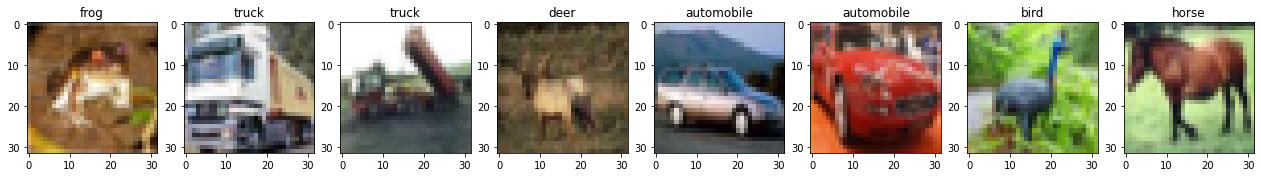

In [8]:
#데이터 시각화 
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

figure, axs = plt.subplots(figsize = (22,6), nrows = 1, ncols = 8)
for i in range(8):
  axs[i].imshow(train_images[i])
  label = train_labels[i].squeeze() #1차원으로 축소
  axs[i].set_title(NAMES[int(label)])

In [9]:
#데이터 전처리
#image array 가 0-255 사이의 값을 가지고 있어 pixel intensity 가 크다 => 0-1 값으로 바꿔줘야 한다

train_images, train_labels = np.array(train_images/255.0, dtype = np.float32), np.array(train_labels, dtype = np.float32) 
test_images, test_labels = np.array(test_images/255.0, dtype = np.float32), np.array(test_labels, dtype = np.float32) 

In [12]:
#위에서 확인 했을 때 label 데이터가 2차원이라 1차원으로 바꿔 가주는게 좋음
train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

In [16]:
#one-hot encoding 진행
from tensorflow.keras.utils import to_categorical

train_oh_labels = to_categorical(train_labels)
test_oh_labels = to_categorical(test_labels)

In [13]:
#모델 생성! 필요 모듈 임포트
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

In [14]:
IMAGE_SIZE = 32

In [15]:
#filter 의 개수는 늘려가면서 행렬의 크기는 줄여가면서 convolution 을 실행

def create_model(IMAGE_SIZE = 32):
  input_tensor = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3)) #channel 까지 명시, 한 개의 데이터의 차원 서술
  x = Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(input_tensor)
  x = Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = MaxPooling2D(2)(x)

  x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(input_tensor)
  x = Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = MaxPooling2D(2)(x)

  x = Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')(input_tensor)
  x = Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')(x)
  x = MaxPooling2D(2)(x)

  x = Flatten()(x) 
  x = Dropout(rate = 0.5)(x) #뉴런이 너무 많을 때를 대비하여 뉴런 개수 떨어뜨리기
  x = Dense(300, activation = 'relu')(x)
  x = Dropout(rate = 0.2)(x)
  output = Dense(10, activation = 'softmax')(x)
  
  model = Model(inputs = input_tensor, outputs = output)
  return model

In [18]:
#모델 생성 및 컴파일
model = create_model(IMAGE_SIZE)
model.compile(optimizer = Adam(0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [19]:
#모델 학습 수행
#validation dataset 을 일정 부분 나누어 오버피팅이 일어나는지 확인
history = model.fit(x = train_images, y = train_oh_labels, batch_size = 64, epochs = 30, validation_split = 0.15)

Epoch 1/30
665/665 [==============================] - 34s 37ms/step - loss: 1.4747 - accuracy: 0.4682 - val_loss: 1.2157 - val_accuracy: 0.5663
Epoch 2/30
665/665 [==============================] - 25s 38ms/step - loss: 1.1120 - accuracy: 0.6058 - val_loss: 0.9907 - val_accuracy: 0.6591
Epoch 3/30
665/665 [==============================] - 25s 38ms/step - loss: 0.9728 - accuracy: 0.6569 - val_loss: 0.9241 - val_accuracy: 0.6792
Epoch 4/30
665/665 [==============================] - 24s 36ms/step - loss: 0.8826 - accuracy: 0.6895 - val_loss: 0.8831 - val_accuracy: 0.6935
Epoch 5/30
665/665 [==============================] - 25s 37ms/step - loss: 0.8035 - accuracy: 0.7188 - val_loss: 0.8737 - val_accuracy: 0.6960
Epoch 6/30
665/665 [==============================] - 25s 38ms/step - loss: 0.7329 - accuracy: 0.7411 - val_loss: 0.8709 - val_accuracy: 0.6995
Epoch 7/30
665/665 [==============================] - 25s 38ms/step - loss: 0.6816 - accuracy: 0.7595 - val_loss: 0.8492 - val_accuracy:

validation accuracy 가 train accuracy 에 비해 낮게 나옴

In [20]:
# 테스트 데이터로 성능 평가
model.evaluate(test_images, test_oh_labels)

313/313 [==============================] - 3s 9ms/step - loss: 1.1073 - accuracy: 0.7206


[1.1072677373886108, 0.7206000089645386]

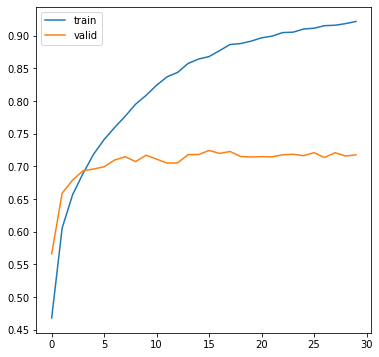

In [21]:
#훈련 데이터의 정확도와 검증 데이터의 정확도 시각화
plt.figure(figsize=(6, 6))
plt.yticks(np.arange(0, 1, 0.05))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()

In [22]:
#model.predict 사용해보기 
#4차원 이미지 배열을 통해 학습함에 주의!!

preds = model.predict(np.expand_dims(test_images[0],axis = 0))

In [23]:
print('예측 결과 shape:', preds.shape)
print('예측 결과:', preds)

예측 결과 shape: (1, 10)
예측 결과: [[9.5477742e-05 5.5379979e-07 3.4994782e-06 9.0410656e-01 4.5795012e-08
  9.5619395e-02 9.4075956e-05 3.9319211e-08 8.0352103e-05 3.1579939e-09]]


In [24]:
#예측 결과를 보고 어떤 클래스 인지 확인
predicted_class = np.argmax(preds, axis = 1) #argmax : 가장 큰 값의 인덱스 가져오기
print('예측 클래스 값: ', predicted_class)
print('예측 클래스 명: ', NAMES[predicted_class])

예측 클래스 값:  [3]
예측 클래스 명:  ['cat']


In [27]:
print(test_labels[0])

3.0


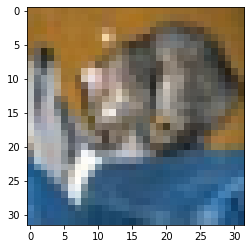

In [25]:
plt.imshow(test_images[0])

생각보다 validation accuracy 와 test accuracy 가 잘 나오지 않아 BatchNormalization 이나 optimizer learning rate 를 조절하는 방법을 더 사용해서 다시 한 번 모델을 돌려봐야 할 것 같다.